Notes
- Predator should have several yuck vectors
- Predator not selected strongly enough against for eating venomous prey

In [48]:
import numpy as np
from tqdm import tqdm
import datetime 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, poisson
from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import animation
from IPython.display import HTML
import pandas as pd
from numba import jit

def generate(num_predators, num_venomous_prey, num_mimics, dim=2, venom_const=0.5, risk_tol_scale=0.1):

    detectors = np.random.uniform(-2, 2, size=(num_predators, dim))
    venomous_signals = np.random.uniform(-2, 2, size=(num_venomous_prey, dim))
    mimic_signals = np.random.uniform(-2, 2, size=(num_mimics, dim))
    
    signals = np.vstack((venomous_signals, mimic_signals))
    
    risk_tols = np.random.exponential(scale=0.1, size=num_predators)
    max_aversions = np.random.uniform(size=num_predators)
    venom_levels = np.concatenate((np.zeros(num_venomous_prey) + venom_const, np.zeros(num_mimics)))

    return detectors, signals, risk_tols, venom_levels, max_aversions

def similarity(detectors, signals, phenotype_type='vector', periodic_boundary=None):
    match phenotype_type:
        case 'vector':
            if periodic_boundary is None:
                dist = np.linalg.norm(detectors[:, np.newaxis] - signals, axis=2)
            else:
                dist = pairwise_periodic_distances_optimized(detectors, signals, periodic_boundary)
            return - dist**2
        case 'bitstring':
            d = signals.shape[1]
            hamming_distances = np.sum(detectors[:, np.newaxis] != signals, axis=2)
            return 1 - hamming_distances/d
        case _:
            raise NotImplementedError

def pairwise_periodic_distances_optimized(v1, v2, b):
    # Reshape v1 and v2 to allow broadcasting
    v1 = np.array(v1)[:, np.newaxis, :]
    v2 = np.array(v2)[np.newaxis, :, :]
    
    # Calculate differences
    diff = np.abs(v1 - v2)
    
    # Apply periodic boundary conditions
    adjusted_diff = np.minimum(diff, 2*b - diff)
    
    # Calculate Euclidean distances
    distances = np.sqrt(np.sum(adjusted_diff**2, axis=2))
    
    return distances

def calculate_preference_matrix(detectors, signals, risk_tols, max_aversions, phenotype_type='vector', periodic_boundary=None):
    similarity_matrix = similarity(detectors, signals, phenotype_type=phenotype_type, periodic_boundary=periodic_boundary) 
    return 1 - max_aversions[:, np.newaxis] * np.exp(similarity_matrix / risk_tols[:, np.newaxis]**2)
    
def calculate_predation_matrix(detectors, signals, risk_tols, max_aversions, handling_time, 
                               attack_freq, R, phenotype_type='vector', 
                               periodic_boundary=None):
    
    preference_matrix = calculate_preference_matrix(detectors, signals, risk_tols, max_aversions, phenotype_type, periodic_boundary)
    n_predators, n_prey = preference_matrix.shape
    n_effective_prey = preference_matrix.sum(1) + R
    n_effective_predators = preference_matrix.sum(0)
    intake_rates = attack_freq / (1 + n_effective_predators[:,None] + attack_freq * handling_time * n_effective_prey)
    return intake_rates.T * preference_matrix, n_effective_prey

def sample_predators(predation_matrix, venom_levels, pred_conversion_ratio, attack_rate, handling_time, R, n_effective_prey, death_rate=0.5):
    num_predators = predation_matrix.shape[0]
    fitnesses = (predation_matrix * (1 - venom_levels) * pred_conversion_ratio - predation_matrix * venom_levels).sum(1)
    fitnesses += 1 - death_rate 
    fitnesses += attack_rate * R / (1 + num_predators + attack_rate * handling_time * n_effective_prey) * pred_conversion_ratio
    means = fitnesses
    means[means < 0] = 0
    # r = 1, E[x] = (1 - p)/p --> p = 1/(E[x] + 1)
    # counts = np.random.negative_binomial(1, 1/(1 + means))  # This may end up being a better function
    counts = np.random.poisson(means)
    return np.repeat(np.arange(num_predators), counts)

def sample_prey(predation_matrix, popcap, venom_levels, r=0.6):
    nv = (venom_levels > 0).sum()
    nm = (venom_levels == 0).sum()
    num_prey = (venom_levels > 0) * nv + (venom_levels == 0) * nm
    fitnesses = r * (1 - num_prey / popcap) - predation_matrix.sum(0)
    means = fitnesses.copy()
    means[means < 0] = 0
    counts = np.random.poisson(means)
    return np.repeat(np.arange(nv + nm), counts)
        

def phenotype_mutate(phenotypes, mutation_rate=0.01, phenotype_type='vector'):
    match phenotype_type:
        case 'vector':
            return phenotypes + np.random.normal(scale=mutation_rate, size=phenotypes.shape)
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError

def impose_periodic_boundary(vectors, boundary=5):
    """
    Imposes periodic boundary conditions on an array of 2D vectors.
    
    Parameters:
    vectors (np.array): Array of shape (n, 2) containing 2D vectors.
    boundary (float): The boundary value for both x and y dimensions. Default is 5.
    
    Returns:
    np.array: Array of shape (n, 2) with periodic boundary conditions applied.
    """
    if boundary is None:
        return vectors
    
    # Ensure the input is a numpy array
    vectors = np.array(vectors)
    
    # Apply periodic boundary conditions
    vectors = np.mod(vectors + boundary, 2 * boundary) - boundary
    
    return vectors


def update(detectors, signals, risk_tols, max_aversions, venom_levels, num_venomous, R, r_R, k_R,
           r_prey,
           handling_time, attack_rate, predator_conversion_ratio, prey_popcap,
           mutation_rate, phenotype_type='vector', periodic_boundary=None, mutate_venom=False, mutate_risk=False, mutate_aversion=False):

    predation_matrix, n_effective_prey = calculate_predation_matrix(
        detectors, signals, risk_tols, max_aversions,               
        handling_time,                  
        attack_rate,       
        R,
        phenotype_type=phenotype_type, 
        periodic_boundary=periodic_boundary
    )

    predator_children = sample_predators(
        predation_matrix, 
        venom_levels, 
        predator_conversion_ratio, 
        attack_rate, 
        handling_time, 
        R,
        n_effective_prey
    )
    
    prey_children = sample_prey(
        predation_matrix, 
        prey_popcap, 
        venom_levels,
        r_prey
    )

    num_predators = predation_matrix.shape[0]
    delta_R = (attack_rate * R / (1 + num_predators + attack_rate * handling_time * n_effective_prey)).sum()
    R += r_R * R * (1 - R / k_R) - delta_R
    R = max(R, 0)

    predator_childrens_detectors = detectors[predator_children]
    prey_childrens_signals = signals[prey_children]
    
    predator_childrens_detectors = phenotype_mutate(
        predator_childrens_detectors, 
        mutation_rate=mutation_rate, 
        phenotype_type=phenotype_type)
    
    prey_childrens_signals = phenotype_mutate(
        prey_childrens_signals, 
        mutation_rate=mutation_rate, 
        phenotype_type=phenotype_type)

    predator_childrens_detectors = impose_periodic_boundary(predator_childrens_detectors, periodic_boundary)
    prey_childrens_signals = impose_periodic_boundary(prey_childrens_signals, periodic_boundary)

    if mutate_risk:
        predator_childrens_risk_tols = phenotype_mutate(
            risk_tols[predator_children], 
            mutation_rate=mutation_rate, 
            phenotype_type=phenotype_type)
        predator_childrens_risk_tols = abs(predator_childrens_risk_tols)
    else:
        predator_childrens_risk_tols = risk_tols[predator_children]

    if mutate_venom:
        prey_childrens_venoms = phenotype_mutate(
            venom_levels[prey_children], 
            mutation_rate=mutation_rate, 
            phenotype_type=phenotype_type)
        
        prey_childrens_venoms[prey_childrens_venoms > 0.9999] = 0.9999
        prey_childrens_venoms[prey_childrens_venoms < 0.0001] = 0.0001
        prey_childrens_venoms[venom_levels[prey_children] == 0] = 0
    else:
        prey_childrens_venoms = venom_levels[prey_children]

    if mutate_aversion:
        predator_childrens_max_aversions = phenotype_mutate(
            max_aversions[predator_children], 
            mutation_rate=mutation_rate, 
            phenotype_type=phenotype_type)

        predator_childrens_max_aversions[predator_childrens_max_aversions > 0.9999] = 0.9999
        predator_childrens_max_aversions[predator_childrens_max_aversions < 0.0001] = 0.0001
    else:
        predator_childrens_max_aversions = max_aversions[predator_children]

    new_num_venomous = (prey_childrens_venoms > 0).sum()

    return predator_childrens_detectors, prey_childrens_signals, predator_childrens_risk_tols, predator_childrens_max_aversions, prey_childrens_venoms, new_num_venomous, R

In [49]:
def plot(detectors_history, nv_history, signals_history, ax):

    n_pred = []
    n_mim = []
    n_ven = []
    for t in range(len(detectors_history)):
        n_pred.append(len(detectors_history[t]))
        n_ven.append(nv_history[t])
        n_mim.append(len(signals_history[t]) - n_ven[-1])
    
    ax.plot(n_pred, '-', c='red', label='Predator')
    ax.plot(n_mim, '-', c='green', label='Mimic')
    ax.plot(n_ven, '-', c='orange', label='Model')
    
    ax.set_xlabel("Generation")
    ax.set_ylabel("Population")
    
    return ax


# @jit(nopython=True)
def centroid(points1, points2, b=None):
    m1 = np.mean(points1, 0)
    m2 = np.mean(points2, 0)
    diff = abs(m1 - m2)
    if b is not None:
        diff = np.minimum(diff, 2*b - diff)
    return np.sqrt(np.sum(diff**2))

@jit(nopython=True)
def bootstrap_centroids(m_sigs, v_sigs, n_bootstraps=500,b=None):
    bootstraps = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        m_sigs_idx = np.random.choice(len(m_sigs), size=len(m_sigs))
        v_sigs_idx = np.random.choice(len(v_sigs), size=len(v_sigs))
        bootstraps[i] = centroid(m_sigs[m_sigs_idx], v_sigs[v_sigs_idx], b)
    return bootstraps

def plot_overlap(detectors_history, signals_history, ax, bootstrap=False, periodic_boundary=2):

    overlap = np.zeros(len(detectors_history))
    if bootstrap:
        hi = np.zeros(len(detectors_history))
        lo = np.zeros(len(detectors_history))
    
    for t in range(len(detectors_history)):
        signals = signals_history[t]
        nv = nv_history[t]
        m_sigs = signals[nv:]
        v_sigs = signals[:nv]

        if (len(m_sigs) == 0) or (len(v_sigs) == 0):
            overlap[t] = 0
            if bootstrap:
                hi[t] = 0
                lo[t] = 0

        else:
            overlap[t] = centroid(m_sigs, v_sigs, periodic_boundary)
        
            if bootstrap:
                bootstraps = bootstrap_centroids(m_sigs, v_sigs, periodic_boundary)
                hi[t] = np.quantile(bootstraps, 0.975)
                lo[t] = np.quantile(bootstraps, 0.025)
    
    tx = ax.twinx()
    tx.plot(overlap, '-k', label='Distance')
    # pd.Series(overlap).rolling(10).mean().plot(ax=tx, color='k', label='Distance')
    if bootstrap:
        tx.fill_between(range(len(hi)), hi, lo, alpha=0.2, color='k')

    

    return tx

def legend(ax):
    # Get handles and labels from the main axis
    handles, labels = ax.get_legend_handles_labels()
    
    # Get handles and labels from the twin axis
    tx = ax.get_shared_x_axes().get_siblings(ax)[0]  # This gets the twin x-axis
    tx_handles, tx_labels = tx.get_legend_handles_labels()
    
    # Combine handles and labels from both axes
    all_handles = handles + tx_handles
    all_labels = labels + tx_labels
    
    # Create the legend
    ax.legend(all_handles, all_labels, ncols=4, loc='best')
    
    # Remove the legend from the twin axis if it exists
    if tx.get_legend():
        tx.get_legend().remove()

    return ax

In [53]:
# Initialize population parameters
scale = 100
num_predators = 1 * scale
num_venomous_prey = 1 * scale
num_mimics = 2 * scale
d = 2
venomosity = 0.7

R = 3 * scale
r_R = 2
k_R = 3 * scale

r_prey = 2

num_generations = 5000
ht = 0.5
af = 1
mutation_rate = 0.01
predator_conversion_ratio = 0.85
prey_popcap = 10 * scale
periodic_boundary = 2

np.random.seed(10)

In [54]:
detectors, signals, risk_tols, venom_levels, max_aversions = generate(num_predators, num_venomous_prey, num_mimics, d, venomosity)

detectors_history    = []
signals_history      = []
risk_tols_history    = []
venom_levels_history = []
max_aversions_history = []
nv_history = []
R_history = []

detectors_history.append(detectors)
signals_history.append(signals)
risk_tols_history.append(risk_tols)
venom_levels_history.append(venom_levels)
nv_history.append(num_venomous_prey)
max_aversions_history.append(max_aversions)

for t in tqdm(range(num_generations)):
    
    d, s, r, ma, v, nv, R = update(
        detectors_history[t], 
        signals_history[t], 
        risk_tols_history[t],
        max_aversions_history[t],
        venom_levels_history[t], 
        nv_history[t], 
        R, r_R, k_R,
        r_prey,
        handling_time = ht,
        attack_rate=af,
        predator_conversion_ratio=predator_conversion_ratio,
        prey_popcap=prey_popcap,
        mutation_rate=mutation_rate, 
        phenotype_type='vector',
        periodic_boundary=periodic_boundary,
        mutate_risk=True,
        mutate_aversion=True,
    )
    
    detectors_history.append(d)
    signals_history.append(s)
    risk_tols_history.append(r)
    venom_levels_history.append(v)
    nv_history.append(nv)
    R_history.append(R)
    max_aversions_history.append(ma)

100%|███████████████████████████████████████| 5000/5000 [01:49<00:00, 45.50it/s]


Text(0, 0.5, 'Model-Mimic Distance')

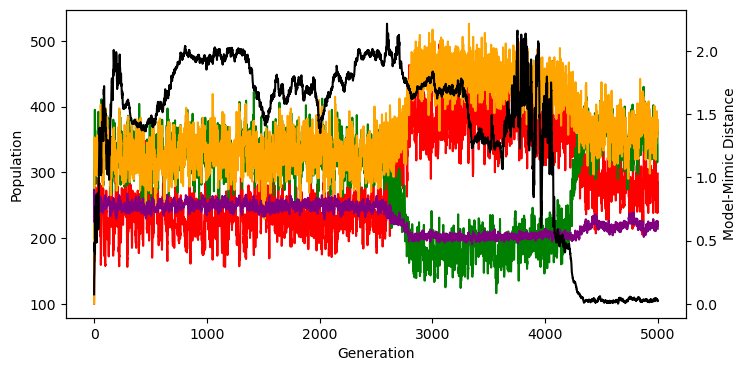

In [55]:
end = 5000
fig, ax = plt.subplots(figsize=(8,4))
plot(detectors_history[:end], nv_history[:end], signals_history[:end], ax=ax)
ax.plot(R_history[:end], color='purple', label='R')
tax = plot_overlap(detectors_history[:end], signals_history[:end], ax=ax, bootstrap=False, periodic_boundary=periodic_boundary)
tax.set_ylabel("Model-Mimic Distance")

In [29]:
steps_per_frame = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), width_ratios = [1.25, 2])

def animate(i):
    # Remove old points
    for artist in ax1.get_lines()+ax1.collections+ax2.get_lines()+ax2.collections:
        artist.remove()

    t = i * steps_per_frame
    num_venomous_prey = nv_history[t]
    pts = []
    ax1.scatter(detectors_history[t][ :, 0], detectors_history[t][ :, 1], color='red', label='predators detectors', s=0.2)
    ax1.scatter(signals_history[t][ :num_venomous_prey, 0], signals_history[t][ :num_venomous_prey, 1], color='orange', label='venomous signals', s=0.2, alpha=0.5)
    ax1.scatter(signals_history[t][ num_venomous_prey:, 0], signals_history[t][ num_venomous_prey:, 1], color='green', label='mimic signals', s=0.2, alpha=0.5)

    plot(detectors_history[:t], nv_history[:t], signals_history[:t], ax=ax2)
    
    return ax1.collections + ax2.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(detectors_history)//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('test_mutate_risk.gif')

In [46]:
from matplotlib.colors import LightSource
from matplotlib import cbook, cm

steps_per_frame = 10
fig, ax = plt.subplots(1, 1, figsize=(6,6), subplot_kw=dict(projection='3d'))

l = 100
x = np.linspace(-2, 2, l)
y = np.linspace(-2, 2, l)
x, y = np.meshgrid(x, y)

def animate(i):
    # Remove old points
    for artist in ax.get_lines()+ax.collections:
        artist.remove()

    t = i * steps_per_frame
    d = detectors_history[t]
    r = risk_tols_history[t]
    s = signals_history[t]
    nv = nv_history[t]
    ma = max_aversions_history[t]
    
    dist = pairwise_periodic_distances_optimized(d, np.array([[x[i, j], y[i, j]] for i in range(l) for j in range(l)]), 2)
                                          
    pref = 1 - ma[:, None] * np.exp(-dist**2 / r[:, None])
    
    z = pref.mean(0).reshape(l, l)
        
    ls = LightSource(270, 45)
    # To use a custom hillshading mode, override the built-in shading and pass
    # in the rgb colors of the shaded surface calculated from "shade".
    rgb = ls.shade(z, cmap=cm.Blues, vert_exag=0.1, blend_mode='soft')
    
    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                           linewidth=0, antialiased=False, shade=False)
    
    ax.set_zlim(0, 1)
    ax.set_zlabel("Prob. eaten")
    ax.set_xlabel(r"$s_x$")
    ax.set_ylabel(r"$s_y$")
    ax.set_box_aspect(None, zoom=0.85)
    
    return ax.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(detectors_history)//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('test3d.gif')

MovieWriter stderr:
Error writing trailer of test3d.gif: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'test3d.gif']' returned non-zero exit status 255.

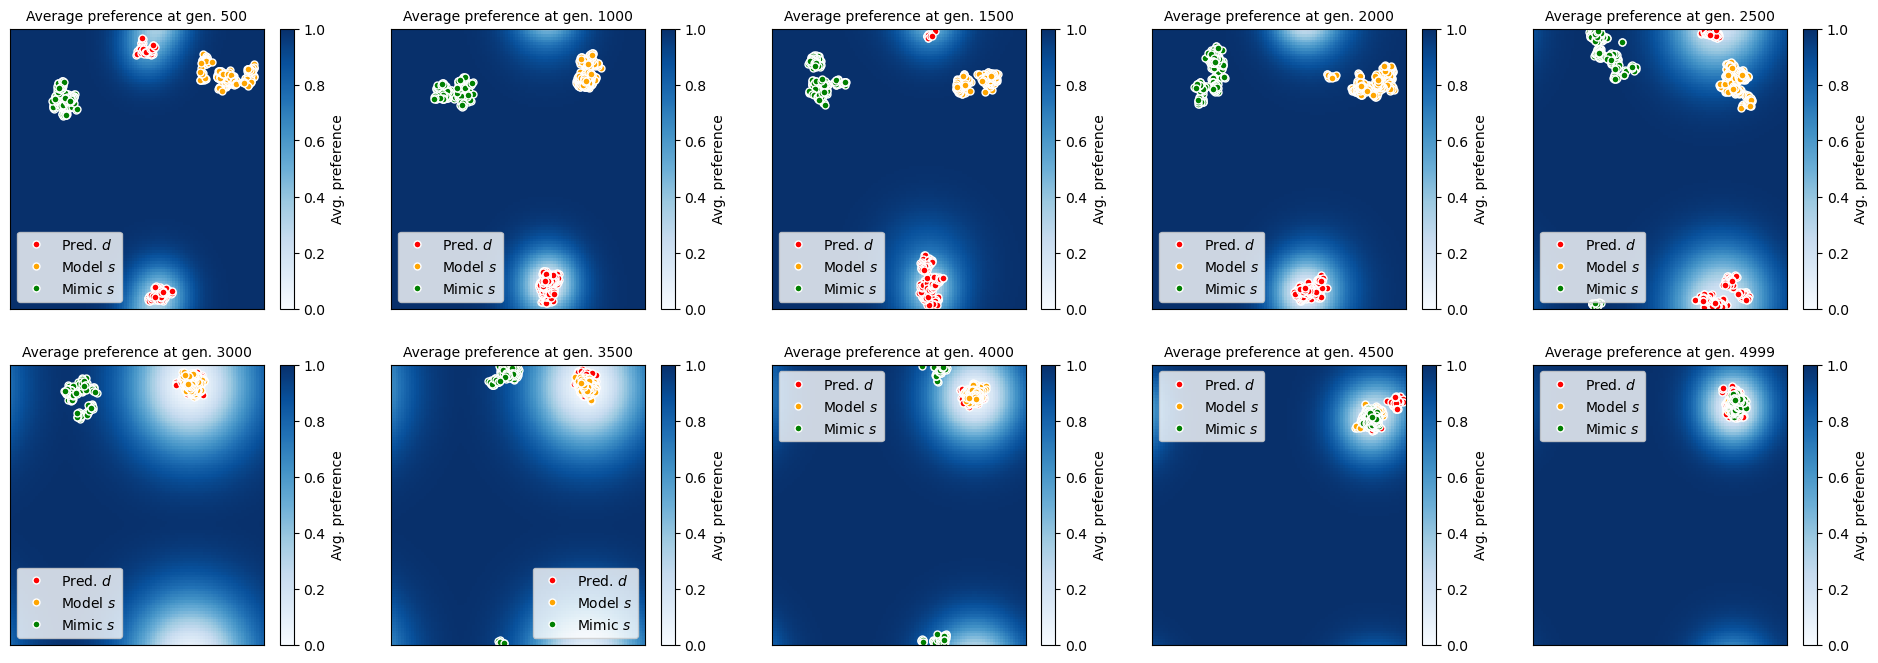

In [57]:
l = 100
x = np.linspace(-2, 2, l)
y = np.linspace(-2, 2, l)
x, y = np.meshgrid(x, y)

fig, axes = plt.subplots(2,5,figsize=(4.75*5,4*2))

for t, ax in zip([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 4999], axes.flat):

    d = detectors_history[t]
    r = risk_tols_history[t]
    s = signals_history[t]
    nv = nv_history[t]
    ma = max_aversions_history[t]
    
    dist = pairwise_periodic_distances_optimized(d, np.array([[x[i, j], y[i, j]] for i in range(l) for j in range(l)]), 2)
                                          
    pref = 1 - np.exp(-dist**2 / r[:, None])
    
    ret = ax.pcolormesh(x, y, pref.mean(0).reshape(l, l), vmin=0, vmax=1, cmap='Blues')
    cbar = fig.colorbar(ret)
    cbar.ax.set_ylabel("Avg. preference", fontsize=10)
    
    ax.plot(d[:,0], d[:, 1], '.', mfc='red', mec='w', ms=10, label=r'Pred. $d$')
    ax.plot(s[:nv,0], s[:nv, 1], '.', mfc='orange', mec='w', ms=10, label=r'Model $s$')
    ax.plot(s[nv:,0], s[nv:, 1], '.', mfc='green', mec='w', ms=10, label=r'Mimic $s$')
    ax.set_title(f"Average preference at gen. {t}", fontsize=10)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.legend()

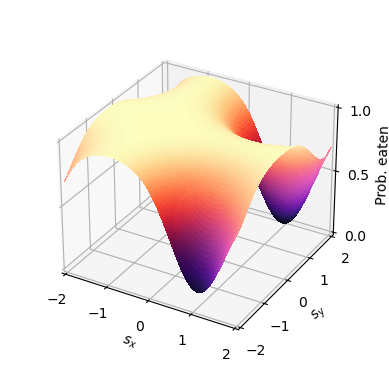

In [59]:
from matplotlib.colors import LightSource
from matplotlib import cbook, cm

t = 3500
d = detectors_history[t]
r = risk_tols_history[t]
s = signals_history[t]
nv = nv_history[t]
ma = max_aversions_history[t]

dist = pairwise_periodic_distances_optimized(d, np.array([[x[i, j], y[i, j]] for i in range(l) for j in range(l)]), 2)
                                      
pref = 1 - ma[:, None] * np.exp(-dist**2 / r[:, None])

z = pref.mean(0).reshape(l, l)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.magma, vert_exag=0.1, blend_mode='soft')

surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

ax.set_zlim(0, 1)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zticks([0, 0.5, 1])
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([-2, -1, 0, 1, 2])

ax.set_zlabel("Prob. eaten")
ax.set_xlabel(r"$s_x$")
ax.set_ylabel(r"$s_y$")
ax.set_box_aspect(None, zoom=0.85)
fig.savefig("example_landscape.png", dpi=300, bbox_inches='tight')

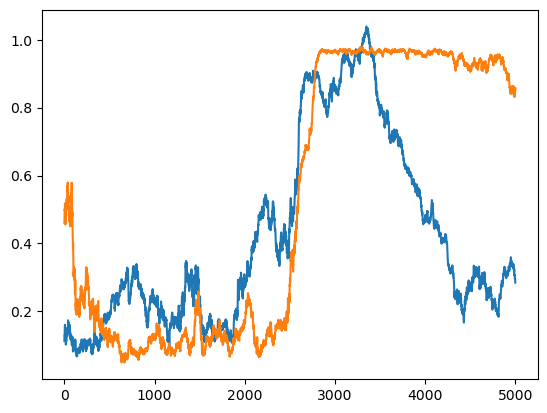

In [61]:
plt.plot([np.mean(r) for r in risk_tols_history])
plt.plot([np.mean(ma) for ma in max_aversions_history])

(0.0, 1.2)

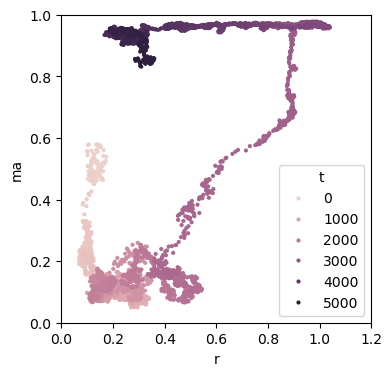

In [74]:
import seaborn as sns
df = pd.DataFrame({'r':[np.mean(r) for r in risk_tols_history], 'ma':[np.mean(ma) for ma in max_aversions_history]})
df['t'] = range(len(df))
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.scatterplot(df, x='r', y='ma', hue='t', marker='.', edgecolor='none')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1.2)